In [1]:
!pwd

/home/daniel/DARM/darm_mujoco/darm_training


In [2]:
import os
os.environ["DARM_MUJOCO_PATH"] = "/home/daniel/DARM/darm_mujoco"
os.getenv('DARM_MUJOCO_PATH')

'/home/daniel/DARM/darm_mujoco'

In [3]:
%%bash
cd ../mujoco_env
bash generate_darm_xml.sh false true

Running generate_darm_xml.sh
Single Finger: false
No Wrist: true






In [5]:
# Check if GCC is installed
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install GCC if absent
!sudo apt update
!sudo apt install build-essential -y

In [5]:
%%bash
cd ..
python setup.py install

running install
running bdist_egg
running egg_info
writing darm_gym_env.egg-info/PKG-INFO
writing dependency_links to darm_gym_env.egg-info/dependency_links.txt
writing requirements to darm_gym_env.egg-info/requires.txt
writing top-level names to darm_gym_env.egg-info/top_level.txt
reading manifest file 'darm_gym_env.egg-info/SOURCES.txt'
writing manifest file 'darm_gym_env.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying darm_gym_env/darm_sf_gym.py -> build/lib/darm_gym_env
copying darm_gym_env/darm_gym.py -> build/lib/darm_gym_env
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/darm_gym_env
copying build/lib/darm_gym_env/darm_sf_gym.py -> build/bdist.linux-x86_64/egg/darm_gym_env
copying build/lib/darm_gym_env/__init__.py -> build/bdist.linux-x86_64/egg/darm_gym_env
copying build/lib/darm_gym_env/multi_darm_gym.py -> build/bdist.linux-x86_64/egg/darm_gym_env
copying build/lib/darm_gy

/home/daniel/miniconda3/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/daniel/miniconda3/lib/python3.8/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
zip_safe flag not set; analyzing archive contents...
darm_gym_env.__pycache__.multi_darm_gym.cpython-38: module references __file__


creating 'dist/darm_gym_env-0.0.1-py3.8.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing darm_gym_env-0.0.1-py3.8.egg
removing '/home/daniel/miniconda3/lib/python3.8/site-packages/darm_gym_env-0.0.1-py3.8.egg' (and everything under it)
creating /home/daniel/miniconda3/lib/python3.8/site-packages/darm_gym_env-0.0.1-py3.8.egg
Extracting darm_gym_env-0.0.1-py3.8.egg to /home/daniel/miniconda3/lib/python3.8/site-packages
darm-gym-env 0.0.1 is already the active version in easy-install.pth

Installed /home/daniel/miniconda3/lib/python3.8/site-packages/darm_gym_env-0.0.1-py3.8.egg
Processing dependencies for darm-gym-env==0.0.1
Searching for gym==0.21.0
Best match: gym 0.21.0
Adding gym 0.21.0 to easy-install.pth file

Using /home/daniel/miniconda3/lib/python3.8/site-packages
Searching for mujoco==2.2.2
Best match: mujoco 2.2.2
Processing mujoco-2.2.2-py3.8-linux-x86_64.egg
mujoco 2.2.2 is already the active ver

In [7]:
# Check if mujoco import is successful
import mujoco

In [ ]:
# If mujoco import fails, update pandas and restart runtime
!pip install pandas -U

In [ ]:
# If GLFW is missing
%%bash
sudo apt-get install libglfw3 -y
sudo apt-get install libglfw3-dev -y
pip install --user glfw

In [ ]:
!pip install stable-baselines3[extra]
!pip install wandb

In [4]:
import gym
from darm_gym_env import DARMEnv
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env.vec_monitor import VecMonitor
from stable_baselines3.common.vec_env.vec_normalize import VecNormalize
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

import wandb
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.callbacks import CallbackList, EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement


from datetime import datetime

In [5]:
run_name = "test1_MF_SB3_SAC"

config = {
    "env_id": "darm/DarmHand-v0", # changed from darm/DarmHand-v0
    "single_finger_env": False,
    "algo": "SAC",
    "rl_lib": "SB3",
    
    "seed": 0,
    "mean_reward_thresh": 1_300,
    "total_timesteps": 10_000_000,
    "pi_net_arch": [128, 256, 256, 128],
    "qf_net_arch": [128, 256, 256, 128],
    "learning_starts": 40_000,
    "num_cpu": 6,
    
    "eval_freq": 2_000, # 5_000
    "max_no_improvement_evals": 10,
    "no_improvement_min_evals": 20,
    
    "log_interval": 20, # episodes
    "wandb_model_save_freq": 2_000, #5_000 timesteps?
    
    "run_local_dir": f"{os.getenv('DARM_MUJOCO_PATH')}/darm_training/results/darm_mf_hand/{run_name}" 
}

In [6]:
notes = """
- The environment was updated such that the target is within a range from the start point
- Velocity penalty was removed and only effort penalty was used
- The reward function was updated according to the reach task reward used in facebookresearch/myosuite [https://github.com/facebookresearch/myosuite/blob/main/myosuite/envs/myo/reach_v0.py]
- The done signal is trigerred only when the fingertip goes beyond a threshold. The episode continues to the maximum timestep otherwise.
- The friction and damping coefficient of the environment is updated. Values are inspired from Deepmind's Mujoco Menagerie [https://github.com/deepmind/mujoco_menagerie/blob/main/shadow_hand/right_hand.xml]
- The range of action from the model was changed to [-1, 1]. This action is mapped to the actual action sent to mujoco e.g [0, 2]]. This change is inspired from values used in OpenAI's Gym Mujoco environments.
- max_episode_steps was updated to 200.
- Velocity vector (size [3,]) was added to observation. Observation size is now (9,)
- Action range was increased to [0, 5]
- Observation warpper to scale observation from m and m/s to cm and cm/s was applied
- Max Tension for Digitorum Extensor Communis was increased to 10
- FIXED: Velocity Observation from (prev_pos - new_pos)/time to (new_pos - prev_pos)/time
- FIXED: Removed weight of 1 from 'sparse', 'solved', and 'done' in reward weighting
- Reduced max_target_th to 5*0.004, 20 mm

- Five-Fingers; No Wrist Environment
- This run was trained on vast_ai using SB3's SAC algo.
"""

tags = ["five_fingers", "sac", "sb3", "vast_ai"]

run = wandb.init(
    project="DARM",
    name=run_name,
    tags=tags,
    notes=notes,
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    # monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)

wandb: Currently logged in as: danieladejumo. Use `wandb login --relogin` to force relogin


In [7]:
from gym.wrappers import TransformObservation
# from gym.wrappers import RescaleAction

create_env = lambda: TransformObservation(gym.make(config["env_id"], single_finger_env=config["single_finger_env"]), lambda obs: obs*100)

In [8]:
NUM_CPU = config["num_cpu"]

env = make_vec_env(create_env, n_envs=NUM_CPU, seed=config["seed"])
# env = VecNormalize(env)   #FIXME: Remember to save norm params if using VecNorm env
# env = VecMonitor(env)

policy_kwargs = dict(net_arch=dict(pi=config["pi_net_arch"], qf=config["qf_net_arch"]))

model = SAC("MlpPolicy", env, verbose=1,
            learning_starts=config["learning_starts"],
            gradient_steps=NUM_CPU, # num of envs
            policy_kwargs=policy_kwargs,
            tensorboard_log=config['run_local_dir'])

Loaded XML file successfully


/home/daniel/miniconda3/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Loaded XML file successfully
Loaded XML file successfully
Loaded XML file successfully
Loaded XML file successfully
Loaded XML file successfully
Using cpu device


In [9]:
eval_env = make_vec_env(create_env, n_envs=1, seed=config["seed"])

# Stop training when the model reaches the reward threshold
# reward_thresh_callback = StopTrainingOnRewardThreshold(reward_threshold=config["mean_reward_thresh"], verbose=1)

# Stop training if there is no improvement after more than N evaluations
# stop_train_callback = StopTrainingOnNoModelImprovement(
#     max_no_improvement_evals=config["max_no_improvement_evals"], 
#     min_evals=config["no_improvement_min_evals"], 
#     verbose=1)

eval_callback = EvalCallback(eval_env, 
                             best_model_save_path=f"{config['run_local_dir']}/models/best",
                             log_path=f"{config['run_local_dir']}/models/best/logs", 
                             eval_freq=config["eval_freq"],
                             # callback_on_new_best=reward_thresh_callback,
                             # callback_after_eval=stop_train_callback,
                             deterministic=True, render=False, verbose=1)

wandb_callback=WandbCallback(model_save_path=f"{config['run_local_dir']}/models",
                             model_save_freq=config["wandb_model_save_freq"],
                             verbose=2)

# Create the callback list
callback = CallbackList([wandb_callback, eval_callback])
callback

Loaded XML file successfully


In [10]:
try:
    model.learn(total_timesteps=config["total_timesteps"], 
                log_interval=config["log_interval"], 
                tb_log_name=run_name,
                callback=callback)
except Exception as e:
    print("Exception caught:")
    print(e)
finally:
    # timestamp = f"{datetime.now().date()}__{datetime.now().time()}"
    print("Saving last checkpoint")
    model_name = f"{config['run_local_dir']}/models/last_model"
    model.save(model_name)
    print(f"Last checkpoint saved in: {model_name}")

Logging to /home/daniel/DARM/darm_mujoco/darm_training/results/darm_mf_hand/test1_MF_SB3_SAC/test1_MF_SB3_SAC_3


/home/daniel/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.29     |
|    ep_rew_mean     | -11      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 48       |
|    time_elapsed    | 1        |
|    total_timesteps | 54       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.32     |
|    ep_rew_mean     | -10.2    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 48       |
|    time_elapsed    | 2        |
|    total_timesteps | 102      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 49       |
|    time_elapsed    | 3        |
|    total_timesteps | 150      |
--------------

KeyboardInterrupt: 

In [11]:
# Finish the run if it's final
run.finish()
print(f"Finished run {run_name}")

Finished run test1_MF_SB3_SAC


In [12]:
env.close()
eval_env.close()

In [ ]:
# MORE TRAINING

# LOAD TRAINED MODEL
# ########## PATHS SHOULD BE UPDATED
# try:
#     model.learn(total_timesteps=10_000_000, log_interval=8, tb_log_name="PlainDarmEnv",
#                     callback=WandbCallback(model_save_path=f"checkpoints/wandb/{run.id}",
#                                            model_save_freq=10, verbose=2)
#                )
#     # Add calbacks
# except Exception as e:
#     print("Exception caught:")
#     print(e)
# finally:
#     timestamp = f"{datetime.now().date()}__{datetime.now().time()}"
#     print(f"Saving checkpoint {timestamp}")
#     model_name = f"./checkpoints/darm_sf_hand_{timestamp}"
#     env_norm_name = f"./checkpoints/darm_sf_hand_env_norm_{timestamp}"
#     model.save(model_name)
#     # env.save(env_norm_name) # FIXME: Remember to save norm params if using VecNorm env
    

In [ ]:
env.close()
eval_env.close()

### DONE TRAINING

In [15]:
!pwd

/home/daniel/DARM/darm_mujoco/darm_training


In [16]:
model_name = f"{config['run_local_dir']}/models/last_model"

eval_env = make_vec_env(create_env, n_envs=1, seed=config["seed"])

eval_model = SAC.load(model_name, env=eval_env)
eval_model

Loaded XML file successfully


In [17]:
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the model with 10 evaluation episodes and deterministic=True
mean_reward, std_reward = evaluate_policy(eval_model, env=eval_model.get_env(), 
                                          n_eval_episodes=10, deterministic=True)

# Print the results
print(mean_reward, std_reward)

-10.613694400000002 5.144844616866426


In [19]:
import pprint
import numpy as np
from tqdm import tqdm

create_env_render = lambda: TransformObservation(gym.make(config["env_id"], render_mode="human", single_finger_env=config["single_finger_env"]), lambda obs: obs*100)
env = make_vec_env(create_env_render, n_envs=1, seed=config["seed"])

obs = env.reset()
episode_return = 0
episode_length = 0
N_EPISODES = 10
solved = 0
actions = []

for i in tqdm(range(N_EPISODES)):
    done = False
    while not done:
        # env.render()
        action, _states = eval_model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        actions.append(info[0]["action"])
        episode_return += reward[0]
        episode_length += 1
        done = done[0]
        
  #  print(f"Episode Return: {episode_return} Episode Length: {episode_length}")
    info[0]["model_action"] = action
    # pprint.pprint(info[0])
  # print(f"Solved: {info[0]['reward']['solved']}")
    solved += info[0]['reward']['solved'][0]
    # info["model_action"] = action
    # pprint.pprint(info)
    
    done = False
    episode_return = 0
    episode_length = 0

env.close()
print(f"{solved}/{N_EPISODES} Solved")

Loaded XML file successfully


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


0/10 Solved


In [101]:
actions = np.asarray(actions)

tendon_tensions = []
tendon_names = ["Dorsal Interossei",
                "Palmar Interossei",
                "Extensor Digitorum Communis",
                "Flexor Digitorum Profundus",
                "Flexor Digitorum Superficialis"]


for i in range(5):
    tendon_tensions.append(actions[:, i])

tendon_tensions = np.asarray(tendon_tensions)
tendon_tensions.shape

(5, 195072)

In [102]:
import pandas as pd

tendon_tensions_dict = {}

for tendon_name, tensions in zip(tendon_names, tendon_tensions):
    tendon_tensions_dict[tendon_name] = tensions

tensions_df = pd.DataFrame(tendon_tensions_dict)
tensions_df.describe()

Dorsal Interossei  Palmar Interossei  Extensor Digitorum Communis  \
count      195072.000000      195072.000000                195072.000000   
mean            0.950422           0.767148                     3.509327   
std             1.014455           0.936925                     1.026986   
min             0.001007           0.000811                     0.000827   
25%             0.244022           0.115738                     2.881964   
50%             0.590215           0.373623                     3.788050   
75%             1.207549           1.124003                     4.289469   
max             4.999928           5.000000                     4.999597   

       Flexor Digitorum Profundus  Flexor Digitorum Superficialis  
count               195072.000000                   195072.000000  
mean                     1.329884                        0.429009  
std                      0.747989                        0.561555  
min                      0.000035                        0.000511  
25%                      0.832723                        0.155681  
50%                      1.291511                        0.288769  
75%                      1.689200                        0.432691  
max                      4.999947                        4.991437

count    195072.000000
mean          0.950422
std           1.014455
min           0.001007
25%           0.244022
50%           0.590215
75%           1.207549
max           4.999928
Name: Dorsal Interossei, dtype: float64

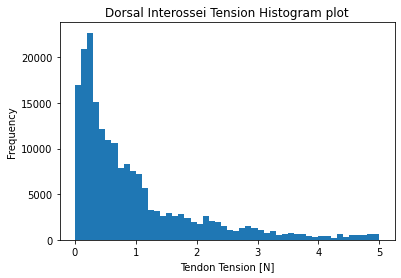

In [126]:
tendon_idx = 0
# tensions_df[tensions_df.columns[tendon_idx]].plot(kind='density', xlim=(-0.5,5.5))
tensions_df[tensions_df.columns[tendon_idx]].plot(kind='hist', bins=50)
plt.title(f"{tensions_df.columns[tendon_idx]} Tension Histogram plot")
_ = plt.xlabel("Tendon Tension [N]")
# _ = plt.ylabel("Count")

tensions_df[tensions_df.columns[tendon_idx]].describe()

<AxesSubplot: >

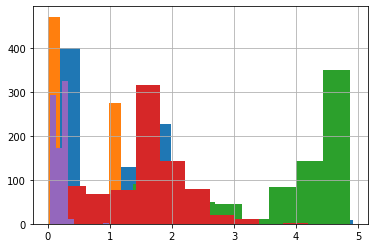

In [48]:
# tensions_df["Flexor Digitorum Superficialis"].hist()
# tensions_df["Extensor Digitorum Communis"].hist()
# tensions_df["Dorsal Interossei"].hist()
# tensions_df["Palmar Interossei"].hist()

In [9]:
import numpy as np
def norm_to_target(obs):
    """
    Returns the norm of each fingertip to the target position
    obs: an observation from the observation space [...fingertip_pos, ...target_pos]
    """
    obs = obs.reshape((-1, 3))
    n_fingertips = len(obs)//2

    fingertip_poses = obs[0:n_fingertips]
    target_poses = obs[n_fingertips:]

    return np.linalg.norm(fingertip_poses-target_poses, ord=2, axis=-1)

In [10]:
obs = env.reset()
episode_return = 0
N_EPISODES = 10

for i in range(N_EPISODES):
  obs = env.reset()
  done = False
  episode_steps = 0
  episode_return = 0
  episode_return_norm = 0

  
  while not done:
    # print("Observation: ", env.unnormalize_obs(obs))
    old_norm = norm_to_target(env.unnormalize_obs(obs))

    action, _states = model.predict(obs, deterministic=True)
    # print("Action: ", action)

    obs, reward, done, info = env.step(action)
    episode_steps += 1
    new_norm = norm_to_target(env.unnormalize_obs(obs))

    # Get actual reward
    unnormalized_reward = env.unnormalize_reward(reward)
    episode_return += unnormalized_reward
    episode_return_norm += reward
    # print(f"Reward: {unnormalized_reward}; Normalized: {reward}")

    # print(f"Next Observation: {env.unnormalize_obs(obs)}")
    # print(f"Change in Norm: {new_norm - old_norm}")
    # print("-----------------------------------------------------")

    # render
    env.render()
  
  print(f"Num Steps: {episode_steps}")
  print(f"Episode Return: {episode_return}")
  print(f"Episode Return Norm: {episode_return_norm}")
  if episode_return > -70: 
    print("Goal Reached!")
  print("\n")

env.close()

Num Steps: 100
Episode Return: [-206.27367]
Episode Return Norm: [-6.1579084]


Num Steps: 7
Episode Return: [238.47386]
Episode Return Norm: [7.1191816]
Goal Reached!


Num Steps: 100
Episode Return: [-112.209465]
Episode Return Norm: [-3.3497994]


Num Steps: 29
Episode Return: [194.17151]
Episode Return Norm: [5.7966194]
Goal Reached!


Num Steps: 100
Episode Return: [-154.97745]
Episode Return Norm: [-4.6265574]


Num Steps: 4
Episode Return: [243.22809]
Episode Return Norm: [7.2611094]
Goal Reached!


Num Steps: 100
Episode Return: [-204.50894]
Episode Return Norm: [-6.1052227]


Num Steps: 100
Episode Return: [-108.443665]
Episode Return Norm: [-3.2373753]


Num Steps: 100
Episode Return: [-206.46591]
Episode Return Norm: [-6.163656]


Num Steps: 100
Episode Return: [-206.59006]
Episode Return Norm: [-6.167353]


